# El objetivo de este notebook es calcular el espectro de potencias 1D usando el bosque de Ly-$\alpha$

Importar modulos

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import fitsio 
import sys
from scipy.fftpack import fft
from glob import glob
sys.path.append('/home/rodrigo/Documentos/env_pru/empca/')
import empca
%matplotlib inline
#%pylab inline 

Se requerirá de una función que haga una interpolación. Esta función se obtuvo de [desispec](https://github.com/desihub/desispec).

In [3]:
def resample_flux(xout, x, flux, ivar=None, extrapolate=False):
    if ivar is None:
        return _unweighted_resample(xout, x, flux, extrapolate=extrapolate)
    else:
        if extrapolate :
            raise ValueError("Cannot extrapolate ivar. Either set ivar=None and extrapolate=True or the opposite")
        a = _unweighted_resample(xout, x, flux*ivar, extrapolate=False)
        b = _unweighted_resample(xout, x, ivar, extrapolate=False)
        mask = (b>0)
        outflux = np.zeros(a.shape)
        outflux[mask] = a[mask] / b[mask]
        dx = np.gradient(x)
        dxout = np.gradient(xout)
        outivar = _unweighted_resample(xout, x, ivar/dx)*dxout
        
        return outflux, outivar

def _unweighted_resample(output_x,input_x,input_flux_density, extrapolate=False) :
    
    # shorter names
    ix=input_x
    iy=input_flux_density
    ox=output_x

    # boundary of output bins
    bins=np.zeros(ox.size+1)
    bins[1:-1]=(ox[:-1]+ox[1:])/2.
    bins[0]=1.5*ox[0]-0.5*ox[1]     # = ox[0]-(ox[1]-ox[0])/2
    bins[-1]=1.5*ox[-1]-0.5*ox[-2]  # = ox[-1]+(ox[-1]-ox[-2])/2
    
    tx=bins.copy()
    if not extrapolate :
        # note we have to keep the array sorted here because we are going to use it for interpolation
        ix = np.append( 2*ix[0]-ix[1] , ix)
        iy = np.append(0.,iy)
        ix = np.append(ix, 2*ix[-1]-ix[-2])
        iy = np.append(iy, 0.)

    ty=np.interp(tx,ix,iy)
    
    #  add input nodes which are inside the node array
    k=np.where((ix>=tx[0])&(ix<=tx[-1]))[0]
    if k.size :
        tx=np.append(tx,ix[k])
        ty=np.append(ty,iy[k])
        
    # sort this node array
    p = tx.argsort()
    tx=tx[p]
    ty=ty[p]
    
    trapeze_integrals=(ty[1:]+ty[:-1])*(tx[1:]-tx[:-1])/2.
    
    trapeze_centers=(tx[1:]+tx[:-1])/2.
    binsize = bins[1:]-bins[:-1]

    if np.any(binsize<=0)  :
        raise ValueError("Zero or negative bin size")
    
    return np.histogram(trapeze_centers, bins=bins, weights=trapeze_integrals)[0] / binsize

Examinar el contenido del catálogo de espectros de QSO de BOSS DR9. Se ha elegio DR9 porque estos archivos ya contienen el espectro continuo de los QSO.

In [4]:
fdir = '/home/rodrigo/Documentos/maestria/ultimo_año/datos_boss_dr9/BOSSLyaDR9_cat.fits'
DM = fitsio.FITS(fdir)
fm = fitsio.read(fdir,'BOSSLyaDR9_cat')
fm.dtype.descr

[('SDSS_NAME', '<U18'),
 ('RA', '>f4'),
 ('DEC', '>f4'),
 ('THING_ID', '>i4'),
 ('PLATE', '>i4'),
 ('MJD', '>i4'),
 ('FIBERID', '>i4'),
 ('Z_VI', '>f4'),
 ('Z_PIPE', '>f4'),
 ('SNR', '>f4'),
 ('SNR_LYAF', '>f4'),
 ('CHISQ_CONT', '>f4'),
 ('CONT_FLAG', '>i4'),
 ('CONT_TEMPLATE', '<U8'),
 ('Z_DLA', '>f4'),
 ('LOG_NHI', '>f4')]

Se deben leer los espectros medidos en cada píxel y almacenarlos en una única matriz que nos lleve a la dirrección donde se encuentran los archivos. Esta vez se hará para un bin en corrimiento al rojo de tamaño 0.2. 

In [5]:
mask = (fm['Z_VI'] > 2.6) & (fm['Z_VI'] < 3.0)
plate = fm['PLATE'][mask]
mjd = fm['MJD'][mask]
fiber = fm['FIBERID'][mask]
RA = fm['RA'][mask]
DEC = fm['DEC'][mask]
z_vi = fm['Z_VI'][mask]
pixels = []
for i in range(plate.size):
    pixels.append('BOSSLyaDR9_spectra/{}/speclya-{}-{}-{}.fits'.format(plate[i],plate[i],mjd[i],str(fiber[i]).zfill(4)))
pixels = np.array(pixels)

In [6]:
print('long. plates = {} \nlong. mjds = {} \nlong. fibers = {} \nnumber of redshifts = {}'.format(len(plate),len(mjd),len(fiber),len(z_vi)))

long. plates = 12329 
long. mjds = 12329 
long. fibers = 12329 
number of redshifts = 12329


Leer y extraer el la longitud de onda (y madarlo al marco en reposo), flujo y el espectro continuo para los primeros 2,000 espectros. Además sólo se va a considerar la región del bosque de Ly-$\alpha$ 

In [7]:
waverf = []
continuos = []
flujos = []
ivar = []
for i in range(len(z_vi))[:2000]:
    specfile = '/home/rodrigo/Documentos/maestria/ultimo_año/datos_boss_dr9/{}'.format(pixels[i])
    spi = fitsio.read(specfile)
    wave = 10**(spi['LOGLAM'])
    wave_rf = wave/(1+z_vi[i])
    maska = (wave_rf > 1040) & (wave_rf < 1200) # región del bosque de Lyalpha
    waverf.append(wave_rf[maska])
    continuos.append(spi['CONT'][maska])
    flujos.append(spi['FLUX'][maska])
    ivar.append(spi['IVAR'][maska])

Ahora se deben normalizar los espectros, para esto se tomará la integral de los espectros en el rango completo del bosque.

In [8]:
lmin=1040.0
lmax=1199.0

integral = []
continuo_nor = []
flux_nor = []
ivar_nor = []
for i in range(len(waverf)):
    sum1=0
    sum2=0
    flag=0
    for j in range(len(waverf[i])):
        if lmin <= waverf[i][j] < lmax :
            sum1+=(continuos[i][j])*(waverf[i][j+1]-waverf[i][j])
            sum2+=(flujos[i][j])*(waverf[i][j+1]-waverf[i][j])
        else:
            break
    integral.append(sum1)
    continuo_nor.append(continuos[i]/sum1)
    flux_nor.append(flujos[i]/sum2)
    ivar_nor.append((ivar[i])*((sum2)**2))

Ya se tiene a los espectros (como a los continuos) normalizados.

### Lo que sigue ahora es contruir el campo de sobredensidades de flujo, es decir, las deltas de flujo.

Recordemos la definición de las deltas.

\begin{equation}
\delta(\lambda) = \frac{F(\lambda)}{\overline{F}(\lambda)} - 1 = \frac{f(\lambda)}{C(\lambda)\overline{F}(\lambda)} - 1,
\end{equation}

donde $F(\lambda) = \dfrac{f(\lambda)}{C(\lambda)}$ es el flujo transmitido o transmisión y $f(\lambda)$ el flujo medido y $C(\lambda)$ es el espectro continuo de los QSO.

Primero debemos concatenar todos los flujos, continuos y longitudes de onda en una sola matriz.

Se debe contruir una nueva longitud de onda para poder hacer la interpolación, además de hacer que todos los espectros tengan el mismo $\Delta \lambda$, que es crucial para calcular el 1D Power Spectrum.

In [13]:
CRVAL1 = 2.6534
CDELT1 = 0.0001
NBLL   = 13637
wwave = 10**(CRVAL1+np.arange(NBLL)*CDELT1)
masw = (wwave > 1040) & (wwave < 1200)
wwave = wwave[masw]

Interpolación

In [14]:
dflux  = np.zeros((len(flux_nor), wwave.size))
divar  = np.zeros((len(flux_nor), wwave.size))
dconti  = np.zeros((len(flux_nor), wwave.size))

for i in range(len(flux_nor)):
    dflux[i], divar[i] = resample_flux(wwave,waverf[i],flux_nor[i], ivar[i]) # interpolation 
    dconti[i] = resample_flux(wwave,waverf[i],continuo_nor[i])

In [15]:
print('Shape wave = {} \nlong. Shape flujo = {} \nlong. Shape continuo = {}'.format(wwave.shape,dflux.shape, dconti.shape))

Shape wave = (621,) 
long. Shape flujo = (2000, 621) 
long. Shape continuo = (2000, 621)


In [22]:
divar[divar<0.] = 0              #
w = sp.sum(divar,axis=0)>0.      #
wwave = wwave[w]                 # For the noise.
dflux = dflux[:,w]               #
divar = divar[:,w]               #
dconti = dconti[:,w]               #
divar[divar>100.] = 100.         #

Procedamos a calcular las $\delta$

In [23]:
def deltas(dflujo, dcont):
    F = np.zeros((dflux.shape))              # Transmision
    for i in range(len(dflujo)):
        F[i] = dflujo[i]/dcont[i]
    Fmean = sp.average(F, axis = 0)          #Transmision promedio  
    delta = F/Fmean - 1                      #Delta
    Dmean = sp.average(delta, axis = 0)
    return F, Fmean, delta, Dmean

In [24]:
T, Tprom, delt, deltprom = deltas(dflux,dconti)

Analizemos los espectros y sus continuos

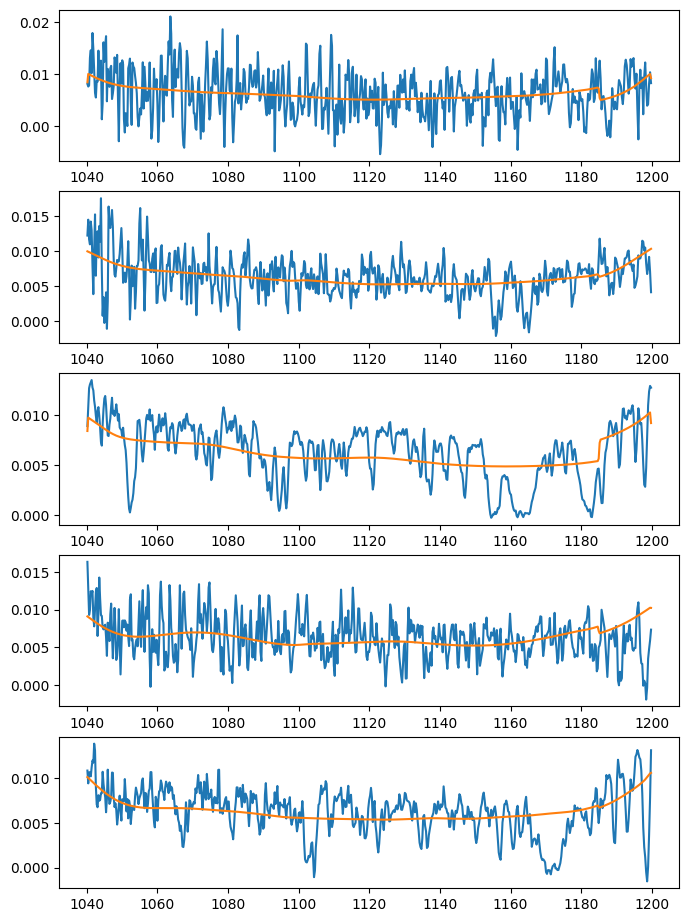

In [25]:
plt.figure(figsize=(8,120),dpi=100)
for i in range(50)[20:25]:
    plt.subplot(50,1,i+1)
    plt.plot(wwave,dflux[i])
    plt.plot(wwave,dconti[i])

Veamos la transmisiones y la transmisión promedio

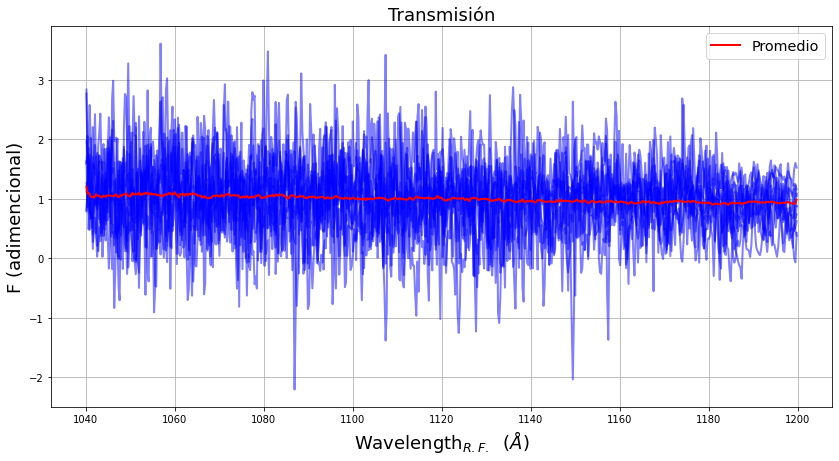

In [26]:
plt.figure(figsize=(14,7))
plt.title('Transmisión',fontsize = 18)
for k in range(len(waverf))[:10]:
    plt.plot(wwave,T[k], color='b',linewidth=2.0,alpha=0.5)
plt.plot(wwave,Tprom, color='r',label='Promedio',linewidth=2.0,alpha=1)
plt.xlabel('Wavelength$_{R.F.}$  ($\AA$)',fontsize = 18)
plt.ylabel('F (adimencional)',fontsize = 18)
plt.legend(fontsize='x-large')
plt.grid()

Finalmente veamos las deltas y la delta promedio.

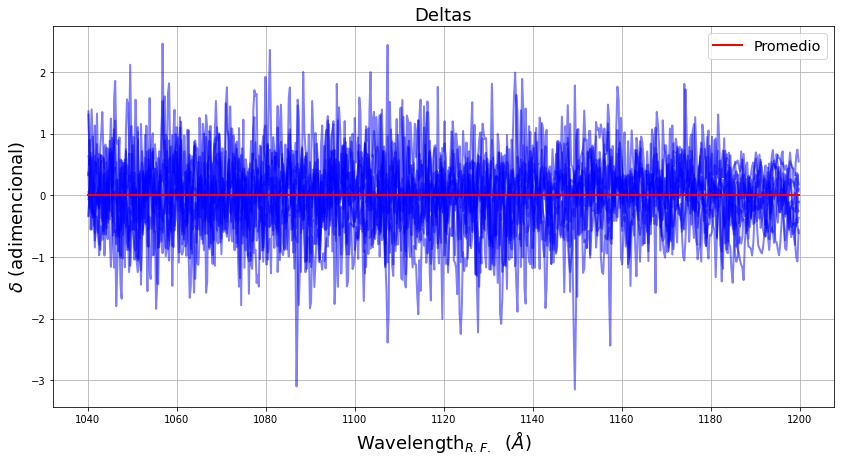

In [27]:
plt.figure(figsize=(14,7))
plt.title('Deltas',fontsize = 18)
for k in range(len(waverf))[:10]:
    plt.plot(wwave,delt[k], color='b',linewidth=2.0,alpha=0.5)
plt.plot(wwave,deltprom, color='r',label='Promedio',linewidth=2.0,alpha=1)
plt.xlabel('Wavelength$_{R.F.}$  ($\AA$)',fontsize = 18)
plt.ylabel('$\delta$ (adimencional)',fontsize = 18)
plt.legend(fontsize='x-large')
plt.grid()

Dado que  $\Delta\log(\lambda) = 1 × 10^{-4}$ e igualmente espaciada para todos los pixels (entiendase esta vez como separación entre longitudes de onda). Lo importante es que esten igualmente espaciadas.

In [28]:
logwave = np.log10(wwave)
print('Δlog(λ) = ', logwave[1]-logwave[0])

Δlog(λ) =  9.999999999976694e-05


Mientras que la diferencia de velocidades entre pixels o velocidad relativa de las líneas de absorción (como función de longitudes de onda).

\begin{equation}
\Delta v (\lambda) = c\Delta z = c \dfrac{\Delta \lambda}{\lambda} = c \Delta[Ln(\lambda)] = c Ln(10)\Delta[\log(\lambda)],
\end{equation}
donde $c$ es la velocidad de la luz. c = 300,000 km/s.

Esta relación se cumple para $z\leq 1$, entonces ¿Es correcto usarla para los QSO que tienen $z≥ 1$?

In [29]:
from scipy.constants import speed_of_light as speed_light
print('c = ', speed_light,'km/s')
Dv = (speed_light/1000.0)*np.log(10)*(logwave[1]-logwave[0])
#Dv = (speed_light/1000.0)*np.log(10)*len(delt[0])*(logwave[1]-logwave[0])
print('Δv(λ) = ', Dv,'km/s')

c =  299792458.0 km/s
Δv(λ) =  69.02976447812347 km/s


Ahora se debe cambiar $\delta(\lambda) \rightarrow \delta(\Delta v)$ 

## Calcular el 1D Power Spectrum

Lo que se debe hacer es aplicar la transformada de Fourier al campo $\delta(\Delta v)$, donde el vector de onda será $k = \dfrac{2\pi}{\Delta v}$ cuyas unidades son $(km/s)^{-1}$.

In [53]:
def pk1d(vel, deltasv):
    ####
    nb_pixels = len(deltasv[0])
    nbin_fft = nb_pixels//2 + 1
    Pk = np.zeros((len(deltasv),nbin_fft))
    for i in range(len(deltasv)):
        #Hacer FFT
        fftdelta = fft(deltasv[i])
        #Calcular 1DPS
        fftdelta = fftdelta[:nbin_fft]
        Pk[i] = (fftdelta.real**2 + fftdelta.imag**2) * (vel*nb_pixels)/(nb_pixels**2)
    Pkm = sp.average(Pk, axis=0)
    #std = np.std(Pk, axis = 0 ) 
    k = np.arange(nbin_fft,dtype=float)*2*sp.pi/(vel*nb_pixels)                       #  k=2π/Δv
    return k, Pkm

In [66]:
def pk1noise(vel, deltasvv):
    ####
    nb_pixels = len(deltasvv)
    nbin_fft = nb_pixels//2 + 1
    #Hacer FFT
    fftdelta = fft(deltasvv)
    #Calcular 1DPS
    fftdelta = fftdelta[:nbin_fft]
    Pk = (fftdelta.real**2 + fftdelta.imag**2) * (vel*nb_pixels)/(nb_pixels**2)
    k = np.arange(nbin_fft,dtype=float)*2*sp.pi/(vel*nb_pixels)                       #  k=2π/Δv
    return k, Pk

In [67]:
def pknoise(vel,noise):
    ####
    nb_pixels = len(noise[0])
    nbin_fft = nb_pixels//2 + 1
    pknois = np.zeros((len(noise),nbin_fft))
    #
    for i in range(len(noise)):
        nb_noise_exp = 10
        Pk = np.zeros(nbin_fft)
        err = np.zeros(nb_pixels)
        noises = noise[i]
        w = noises>0
        err[w] = 1.0/np.sqrt(noises[w])
        for j in range(nb_noise_exp):
            delta_exp= np.zeros(nb_pixels)
            delta_exp[w] = sp.random.normal(0.,err[w])
            j,Pk_exp = pk1noise(vel,delta_exp) #k_exp unused, but needed
            Pk += Pk_exp
        Pk /= float(nb_noise_exp)
        pknois[i] = Pk
    Pknoises = np.average(pknois, axis=0)
    return Pknoises

In [64]:
k1d, Pk1d = pk1d(Dv, delt)

In [68]:
Pk_noise = pknoise(Dv, divar)

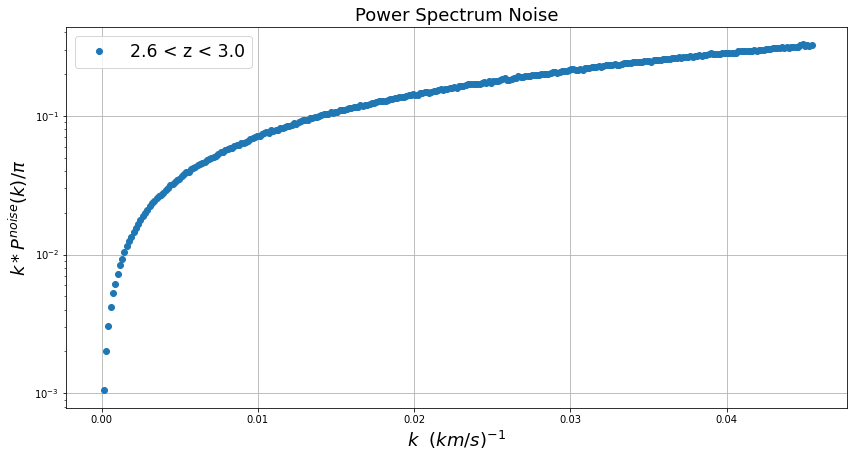

In [70]:
plt.figure(figsize=(14,7))
plt.title('Power Spectrum Noise',fontsize = 18)
plt.plot(k1d,k1d*Pk_noise/np.pi,'o', label = '2.6 < z < 3.0')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{noise}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

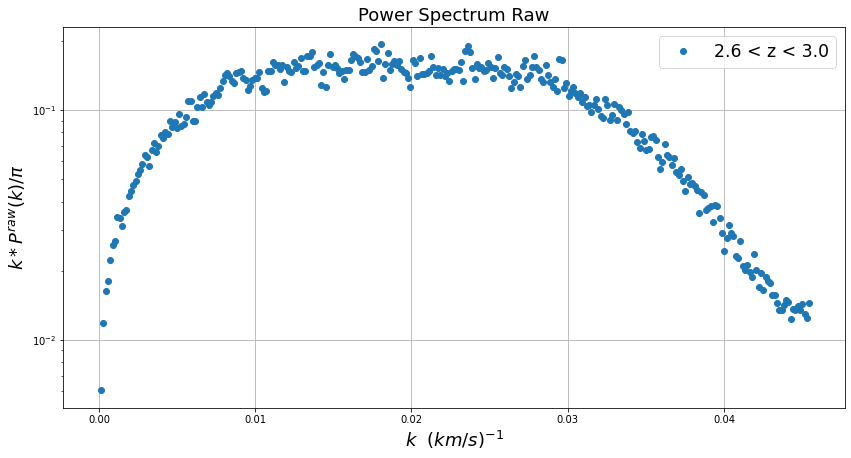

In [86]:
plt.figure(figsize=(14,7))
plt.title('Power Spectrum Raw',fontsize = 18)
plt.plot(k1d,k1d*Pk1d/np.pi,'o', label = '2.6 < z < 3.0')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{raw}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

In [72]:
def window(vel, reso, kvec):
    nb_bin_FFT = len(kvec)
    cor = np.ones(nb_bin_FFT)

    sinc = np.ones(nb_bin_FFT)
    sinc[kvec>0.] = sp.sin(kvec[kvec>0.]*vel/2.0)/(kvec[kvec>0.]*vel/2.0)

    cor *= sp.exp(-((kvec*reso)**2)/2.0)
    cor *= sinc
    Win = cor**2
    return Win

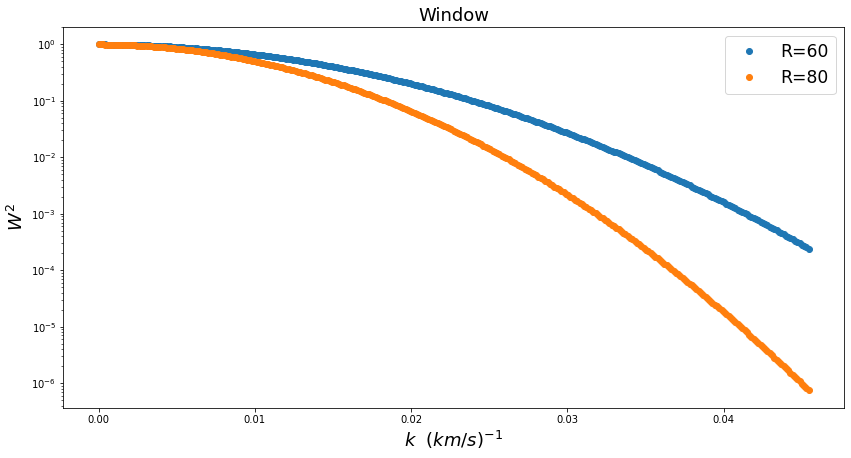

In [77]:
win1 = window(Dv,60,k1d)
win2 = window(Dv,80,k1d)

plt.figure(figsize=(14,7))
plt.title('Window',fontsize = 18)
plt.plot(k1d,win1,'o', label = 'R=60')
plt.plot(k1d,win2,'o', label = 'R=80')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$W^{2}$',fontsize = 18)
plt.legend(fontsize='xx-large')

In [73]:
wind = window(Dv,60,k1d)

In [87]:
Pk1DT = (Pk1d - Pk_noise)/wind
Pk2 = (Pk1d - Pk_noise)/win2

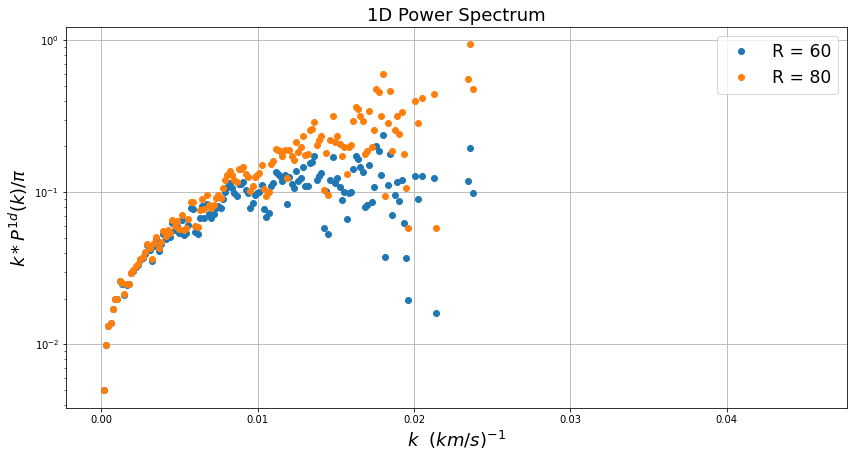

In [91]:
plt.figure(figsize=(14,7))
plt.title('1D Power Spectrum',fontsize = 18)
plt.plot(k1d,k1d*Pk1DT/np.pi,'o', label = 'R = 60')
plt.plot(k1d,k1d*Pk2/np.pi,'o', label = 'R = 80')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{1d}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

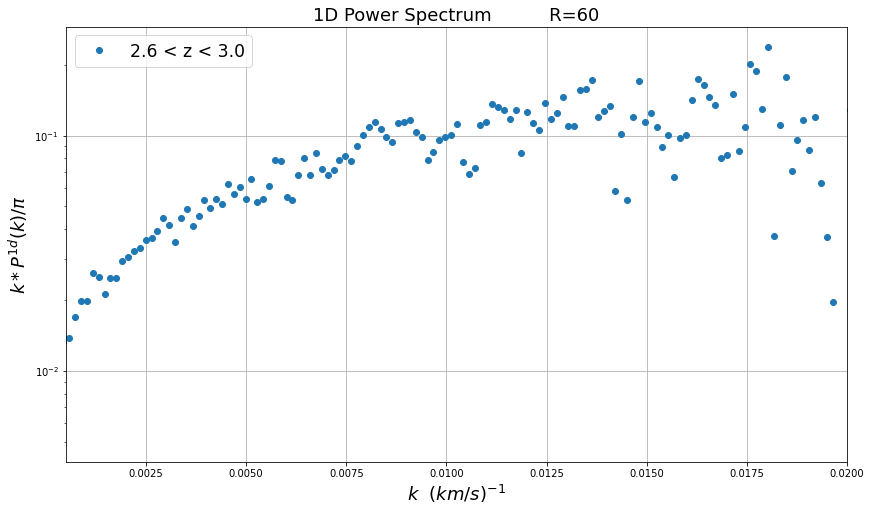

In [92]:
plt.figure(figsize=(14,8))
plt.title('1D Power Spectrum          R=60',fontsize = 18)
plt.plot(k1d,k1d*Pk1DT/np.pi,'o', label = '2.6 < z < 3.0')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{1d}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.xlim(0.0005,0.02)
plt.grid()

In [93]:
k1d[1]-k1d[0]

0.000146572291136898

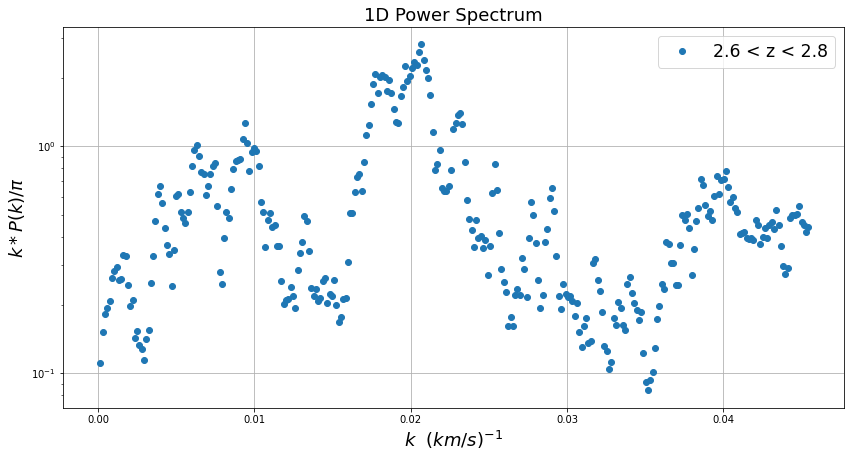

In [91]:
plt.figure(figsize=(14,7))
plt.title('1D Power Spectrum',fontsize = 18)
plt.plot(k1d,k1d*Pk1d/np.pi,'o', label = '2.6 < z < 2.8')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

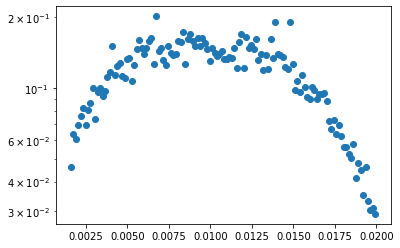

In [200]:
mm = (k1d>0.0015) & (k1d < 0.02)
plt.plot(k1d[mm],k1d[mm]*Pk1d[mm],'o')
plt.yscale('log')

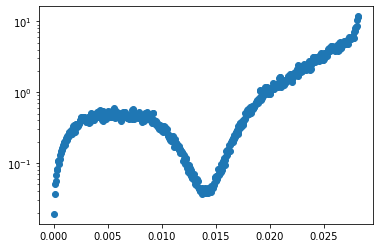

In [189]:
plt.plot(k1d,k1d*Pk1d,'o')
plt.yscale('log')

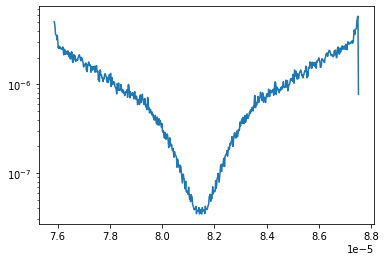

In [155]:
plt.plot(kvec,kvec*Pk1d/np.pi)
plt.yscale('log')